# Walmart Weekly Sales Forecasting

In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

<b>Loading Train & Test dataset

In [2]:
train1 = pd.read_csv('train.csv',parse_dates= ['Date'])
test1 = pd.read_csv('test.csv',parse_dates= ['Date'])

In [3]:
train1.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
train1.tail(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [5]:
test1.head(5)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


<b>Combining test & train 

In [6]:
data= pd.concat([train1,test1], axis=0)

C:\Users\Aanchal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [7]:
data.shape

(536634, 5)

In [8]:
train= data[0:421569]

In [9]:
test= data[421570:]

In [10]:

print("the structure of train data is ", train.shape)
print("the structure of test  data is ", test.shape)

the structure of train data is  (421569, 5)
the structure of test  data is  (115064, 5)


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421569 entries, 0 to 421568
Data columns (total 5 columns):
Date            421569 non-null datetime64[ns]
Dept            421569 non-null int64
IsHoliday       421569 non-null bool
Store           421569 non-null int64
Weekly_Sales    421569 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 16.5 MB


<b>Encode IsHoliday True & False to 1,0

In [12]:

#Converting target variable attack into normal & attack i.e 0 &1
train['IsHoliday']= np.where((train.IsHoliday==True),1,0)
test['IsHoliday']= np.where((test.IsHoliday==True),1,0)

C:\Users\Aanchal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Aanchal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<b>Year / Month / Week / are extracted from 'Date' column

In [13]:
import calendar
train['Month'] = train['Date'].dt.month
train['Month'] = train['Month'].apply(lambda x: calendar.month_abbr[x])
train['Year'] = train['Date'].dt.year
train['Week'] = train['Date'].dt.week

C:\Users\Aanchal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Aanchal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Aanchal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [14]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
train.set_index('Date', inplace=True)

In [15]:
train.head()

,Dept,IsHoliday,Store,Weekly_Sales,Month,Year,Week
Date,,,,,,,
2010-02-05,1,0,1,24924.50,Feb,2010,5
2010-02-12,1,1,1,46039.49,Feb,2010,6
2010-02-19,1,0,1,41595.55,Feb,2010,7
2010-02-26,1,0,1,19403.54,Feb,2010,8
2010-03-05,1,0,1,21827.90,Mar,2010,9


<b>Visualising Weekly Sales of Sore 1 with D=different con=mbinations of Departments

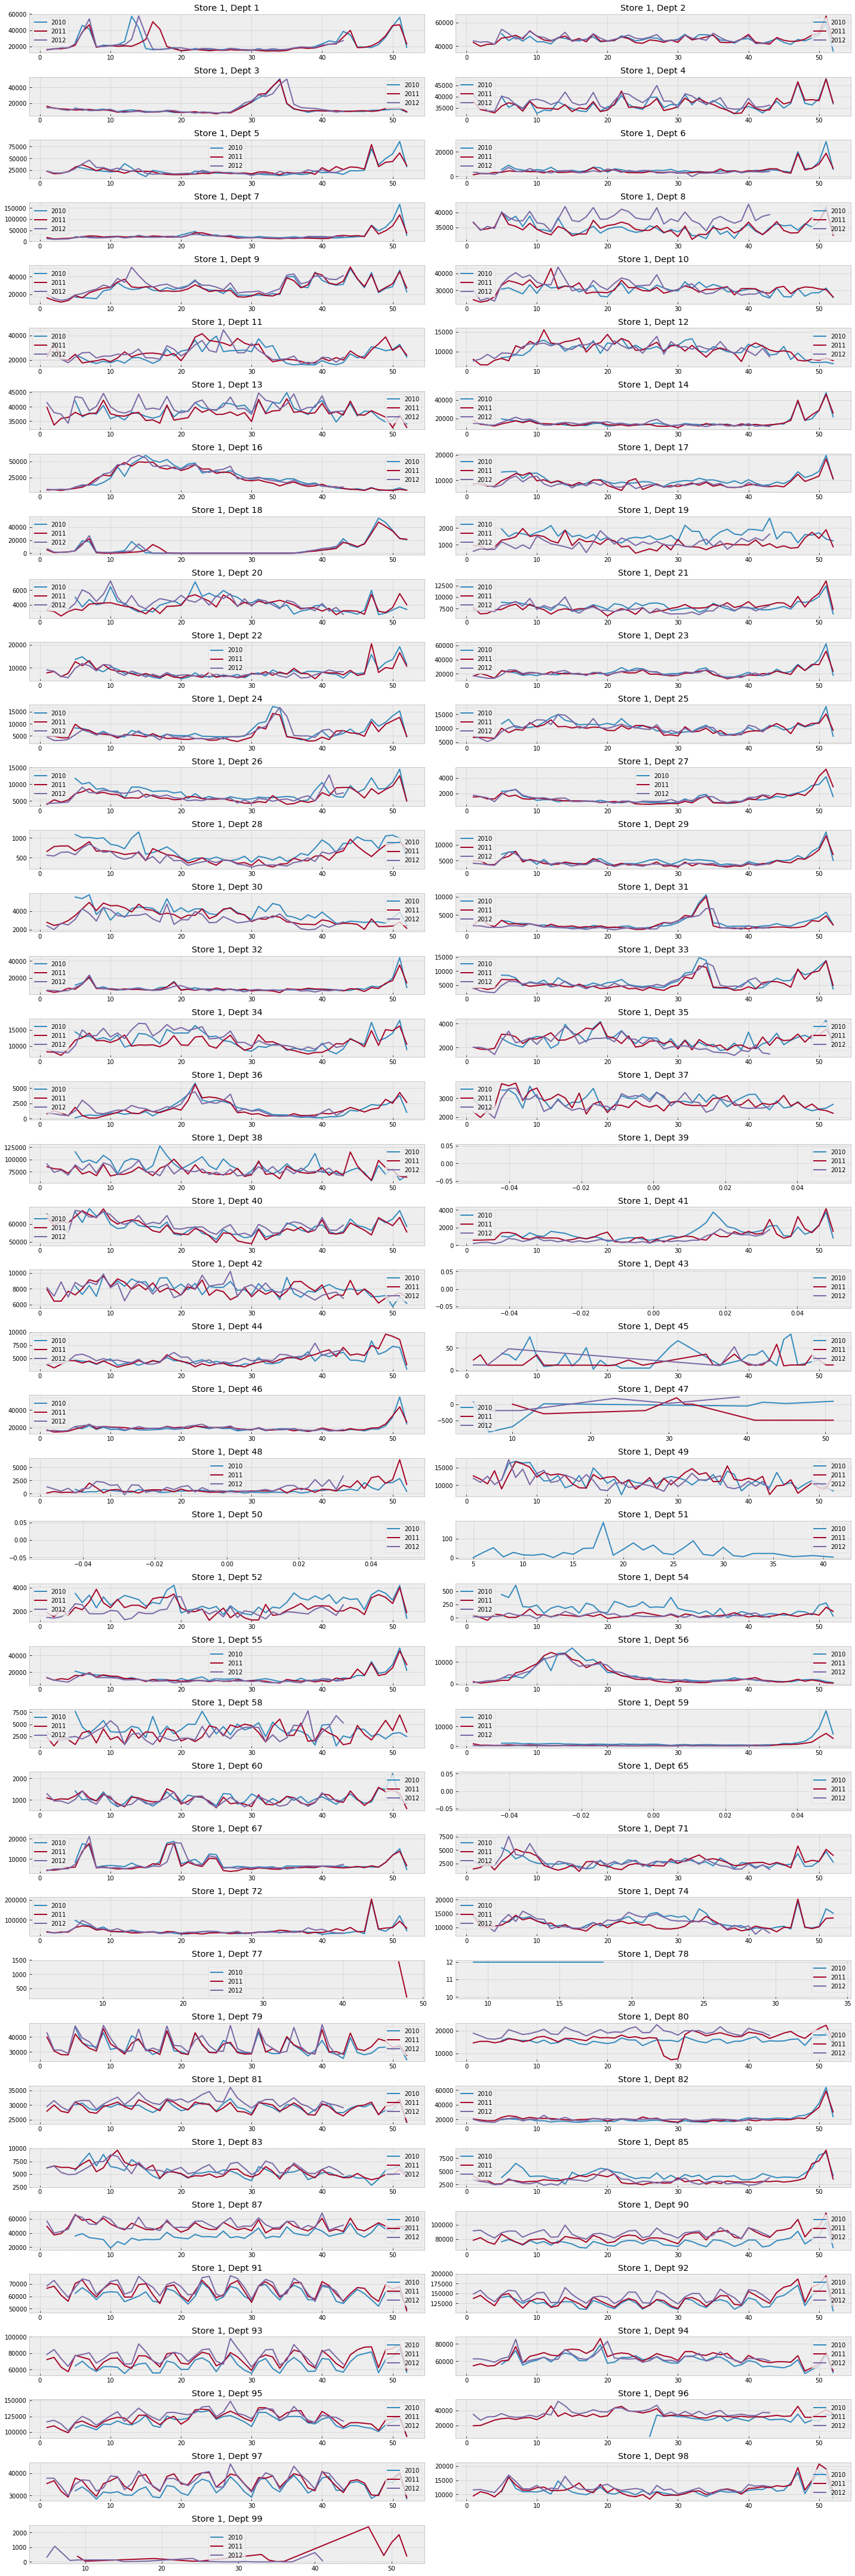

In [16]:
store_nbr = 1
plt.figure(figsize=(20, 60))
for idx, item_nbr in enumerate(set(train['Dept'])):
    
    plt.subplot(int(len(set(train['Dept']))/2)+1, 2, idx+1)
    for year in [2010, 2011, 2012]:

        d_1_1 = train[(train['Year']==year) & 
                       (train['Store']==store_nbr) & 
                       (train['Dept']==item_nbr)] 
        plt.plot(d_1_1['Week'], d_1_1['Weekly_Sales'], label=str(year))
        plt.title('Store {}, Dept {}'.format(store_nbr, item_nbr))
        plt.legend()
plt.tight_layout(pad=1, h_pad=1)
plt.show()

In [17]:
test.head(5)

,Date,Dept,IsHoliday,Store,Weekly_Sales
0,2012-11-02,1,0,1,NaN
1,2012-11-09,1,0,1,NaN
2,2012-11-16,1,0,1,NaN
3,2012-11-23,1,1,1,NaN
4,2012-11-30,1,0,1,NaN


In [18]:
import calendar
test['Month'] = test['Date'].dt.month
test['Month'] = test['Month'].apply(lambda x: calendar.month_abbr[x])
test['Year'] = test['Date'].dt.year
test['Week'] = test['Date'].dt.week

C:\Users\Aanchal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Aanchal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Aanchal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [19]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
test.set_index('Date', inplace=True)

In [20]:
test.head()

,Dept,IsHoliday,Store,Weekly_Sales,Month,Year,Week
Date,,,,,,,
2012-11-02,1,0,1,NaN,Nov,2012,44
2012-11-09,1,0,1,NaN,Nov,2012,45
2012-11-16,1,0,1,NaN,Nov,2012,46
2012-11-23,1,1,1,NaN,Nov,2012,47
2012-11-30,1,0,1,NaN,Nov,2012,48


In [21]:
tn= test[test.Store==1]

In [22]:
tn.head()

,Dept,IsHoliday,Store,Weekly_Sales,Month,Year,Week
Date,,,,,,,
2012-11-02,1,0,1,NaN,Nov,2012,44
2012-11-09,1,0,1,NaN,Nov,2012,45
2012-11-16,1,0,1,NaN,Nov,2012,46
2012-11-23,1,1,1,NaN,Nov,2012,47
2012-11-30,1,0,1,NaN,Nov,2012,48


In [23]:
tn_1=tn[tn.Dept==1]

In [24]:
t2=tn_1['Weekly_Sales']

In [25]:
train.isna().sum()

Dept            0
IsHoliday       0
Store           0
Weekly_Sales    0
Month           0
Year            0
Week            0
dtype: int64

<b>Here find there are some negative Sales, we conclude there were no Sales in there weeks(these are Refund from the purchase of last week) so replace these negative values with 0

In [26]:
train[train['Weekly_Sales']<0]

,Dept,IsHoliday,Store,Weekly_Sales,Month,Year,Week
Date,,,,,,,
2012-08-10,6,0,1,-139.65,Aug,2012,32
2012-05-04,18,0,1,-1.27,May,2012,18
2010-02-19,47,0,1,-863.00,Feb,2010,7
2010-03-12,47,0,1,-698.00,Mar,2010,10
2010-10-08,47,0,1,-58.00,Oct,2010,40
2011-04-08,47,0,1,-298.00,Apr,2011,14
2011-07-08,47,0,1,-198.00,Jul,2011,27
2011-10-14,47,0,1,-498.00,Oct,2011,41
2011-12-23,47,0,1,-498.00,Dec,2011,51


In [27]:
train['Weekly_Sales']= np.where((train['Weekly_Sales']<0),0,train['Weekly_Sales'])

C:\Users\Aanchal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<b>Exploratory Analysis

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Aanchal\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


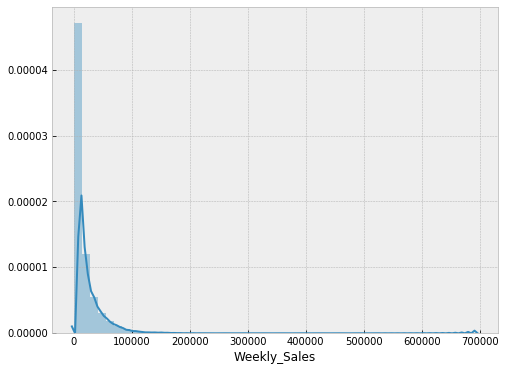

In [29]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['Weekly_Sales'])

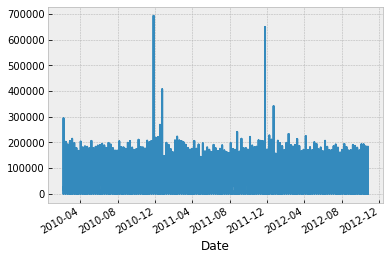

In [30]:
train['Weekly_Sales'].plot()

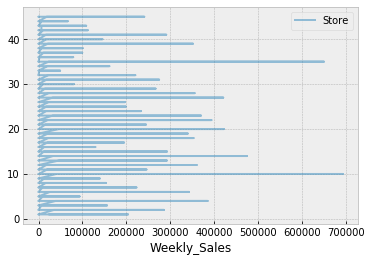

In [31]:
train.plot(kind='line', x='Weekly_Sales', y='Store', alpha=0.5)

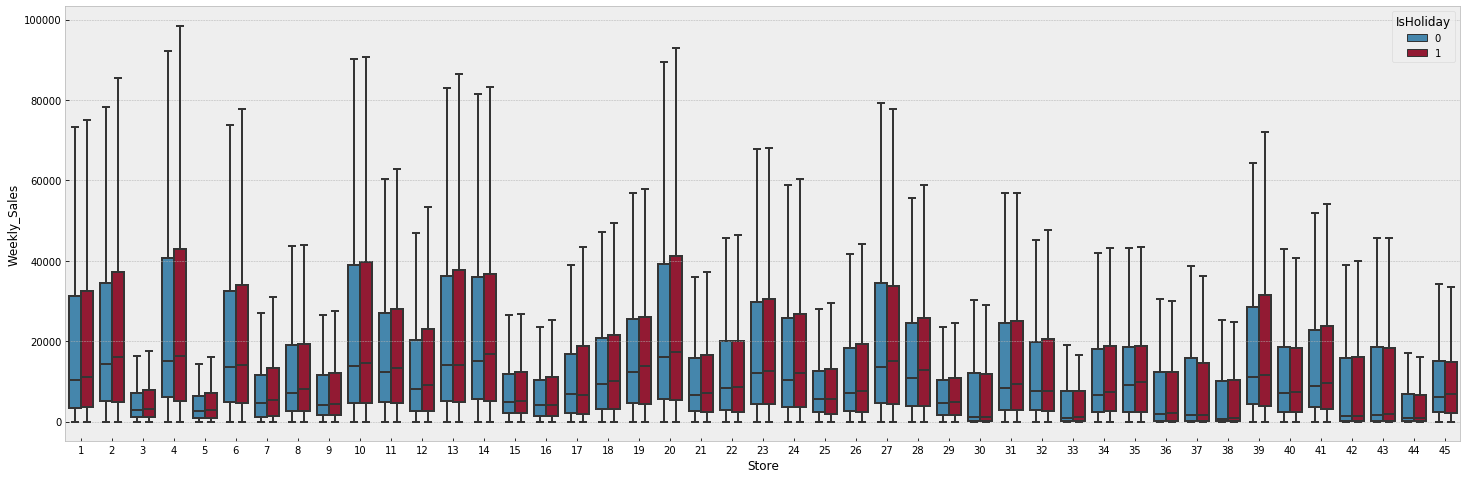

In [32]:
f, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=train, showfliers=False, hue="IsHoliday")
fig

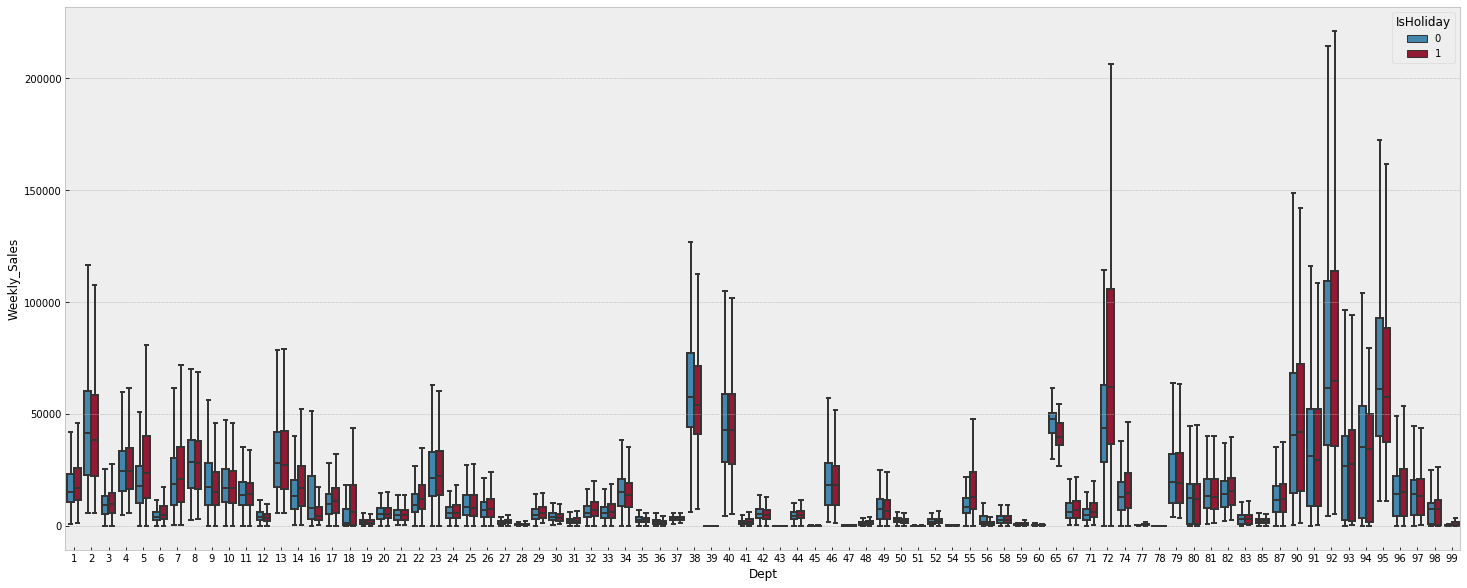

In [33]:
f, ax = plt.subplots(figsize=(25, 10))
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=train, showfliers=False, hue="IsHoliday")
fig

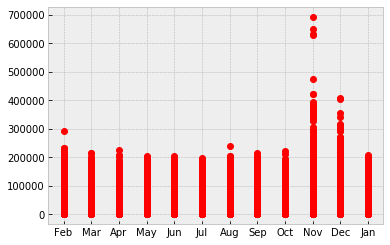

In [34]:
plt.plot(train.Month, train.Weekly_Sales, 'ro')
plt.show()

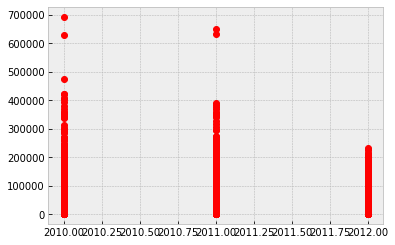

In [35]:
plt.plot(train.Year, train.Weekly_Sales, 'ro')
plt.show()

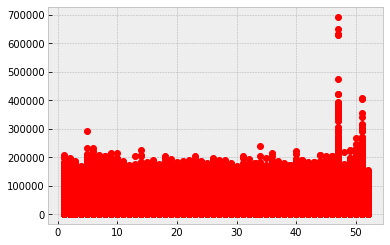

In [36]:
plt.plot(train.Week, train.Weekly_Sales, 'ro')
plt.show()

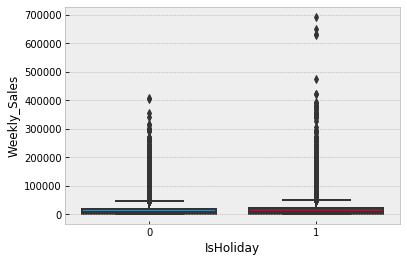

In [37]:
fig=sns.boxplot(x='IsHoliday', y="Weekly_Sales", data=train)
fig

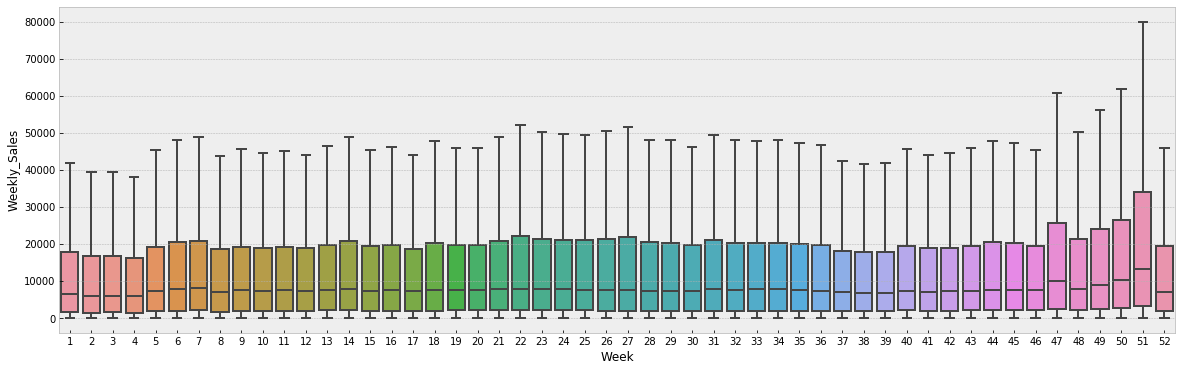

In [38]:
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x='Week', y="Weekly_Sales", data=train, showfliers=False)
fig

<b>As Using Store 1 with each combination of Department number

In [39]:
ts=train[train.Store==1]

In [40]:
ts

,Dept,IsHoliday,Store,Weekly_Sales,Month,Year,Week
Date,,,,,,,
2010-02-05,1,0,1,24924.50,Feb,2010,5
2010-02-12,1,1,1,46039.49,Feb,2010,6
2010-02-19,1,0,1,41595.55,Feb,2010,7
2010-02-26,1,0,1,19403.54,Feb,2010,8
2010-03-05,1,0,1,21827.90,Mar,2010,9
2010-03-12,1,0,1,21043.39,Mar,2010,10
2010-03-19,1,0,1,22136.64,Mar,2010,11
2010-03-26,1,0,1,26229.21,Mar,2010,12
2010-04-02,1,0,1,57258.43,Apr,2010,13


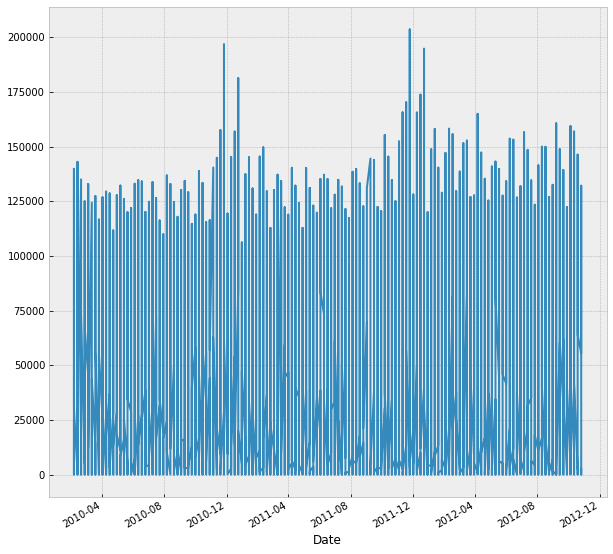

In [41]:
plt.figure(figsize=(10,10))
ts['Weekly_Sales'].plot()

In [42]:
ts.head()

,Dept,IsHoliday,Store,Weekly_Sales,Month,Year,Week
Date,,,,,,,
2010-02-05,1,0,1,24924.50,Feb,2010,5
2010-02-12,1,1,1,46039.49,Feb,2010,6
2010-02-19,1,0,1,41595.55,Feb,2010,7
2010-02-26,1,0,1,19403.54,Feb,2010,8
2010-03-05,1,0,1,21827.90,Mar,2010,9


<b>Using Store1 and Dept 1 combination for Model building

In [43]:
ts_1=ts[ts.Dept==1]

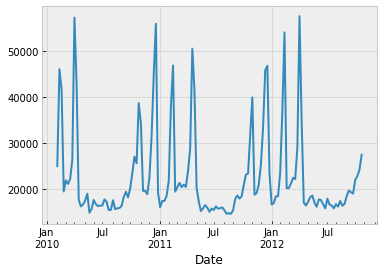

In [62]:
ts_1['Weekly_Sales'].plot()

In [63]:

weekly_sales_data = pd.pivot_table(ts_1, values = "Weekly_Sales", columns = "Year", index = "Month")
weekly_sales_data = weekly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
weekly_sales_data

Year,2010,2011,2012
Month,,,
Jan,NaN,17286.6475,17551.3375
Feb,32990.7700,31440.6575,33670.8250
Mar,22809.2850,20705.8350,22936.1080
Apr,30103.3520,33011.3900,31400.0300
May,16673.5375,17062.9300,17698.2450
Jun,16685.1750,15744.6425,16729.3080
Jul,16383.0020,15771.2460,16617.1975
Aug,16144.7025,14765.4875,16609.1140
Sep,17978.3175,17551.2820,19034.4750


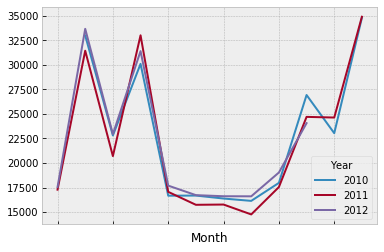

In [64]:
weekly_sales_data.plot()

In [65]:
yearly_sales_data = pd.pivot_table(ts_1, values = "Weekly_Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2010,NaN,32990.7700,22809.285,30103.352,16673.5375,16685.1750,16383.0020,16144.7025,17978.3175,26928.9060,23040.3500,34796.776
2011,17286.6475,31440.6575,20705.835,33011.390,17062.9300,15744.6425,15771.2460,14765.4875,17551.2820,24701.7075,24634.3775,34902.414
2012,17551.3375,33670.8250,22936.108,31400.030,17698.2450,16729.3080,16617.1975,16609.1140,19034.4750,24061.1400,NaN,NaN


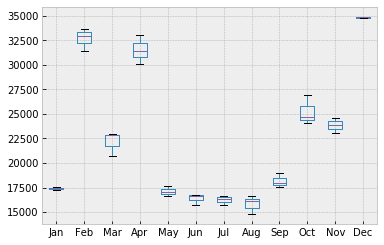

In [66]:
yearly_sales_data.boxplot()

<b>Seasonality – Time Series Decomposition

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [68]:

decomposition = sm.tsa.seasonal_decompose(ts_1['Weekly_Sales'], model='additive', extrapolate_trend=52)

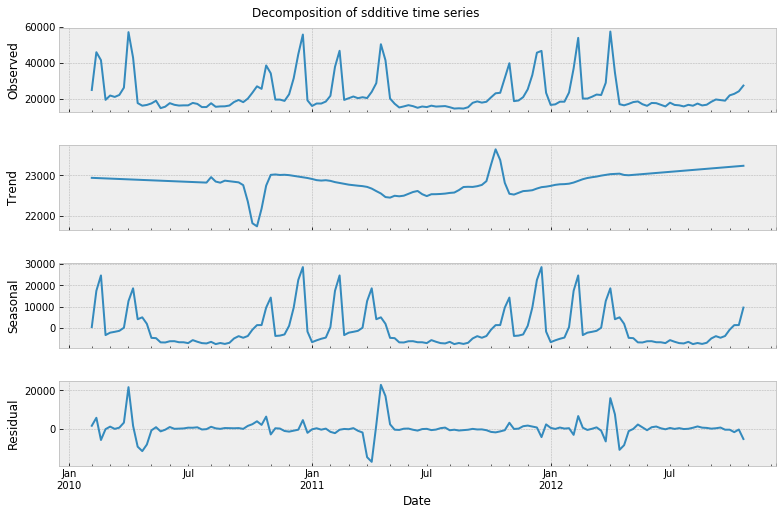

In [69]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of sdditive time series')
plt.show()

In [70]:
decomposition.trend

Date
2010-02-05    22941.200132
2010-02-12    22936.490789
2010-02-19    22931.781446
2010-02-26    22927.072103
2010-03-05    22922.362760
2010-03-12    22917.653418
2010-03-19    22912.944075
2010-03-26    22908.234732
2010-04-02    22903.525389
2010-04-09    22898.816046
2010-04-16    22894.106703
2010-04-23    22889.397361
2010-04-30    22884.688018
2010-05-07    22879.978675
2010-05-14    22875.269332
2010-05-21    22870.559989
2010-05-28    22865.850647
2010-06-04    22861.141304
2010-06-11    22856.431961
2010-06-18    22851.722618
2010-06-25    22847.013275
2010-07-02    22842.303932
2010-07-09    22837.594590
2010-07-16    22832.885247
2010-07-23    22828.175904
2010-07-30    22823.466561
2010-08-06    22958.960577
2010-08-13    22849.238846
2010-08-20    22821.335000
2010-08-27    22871.437019
                  ...     
2012-04-06    23032.133558
2012-04-13    23039.761923
2012-04-20    23044.761250
2012-04-27    23012.495673
2012-05-04    23005.522687
2012-05-11    23014.892

In [71]:
decomp_output = pd.DataFrame(pd.concat([decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid], axis=1))

In [72]:




decomp_output.columns = ['observed', 'Trend', 'Seasonal', 'Irregular']

In [73]:
decomp_output['TSI'] = decomp_output.Trend*decomp_output.Seasonal*decomp_output.Irregular

In [74]:
decomp_output

,observed,Trend,Seasonal,Irregular,TSI
Date,,,,,
2010-02-05,24924.50,22941.200132,530.184424,1453.115444,1.767434e+10
2010-02-12,46039.49,22936.490789,17470.838115,5632.161096,2.256918e+12
2010-02-19,41595.55,22931.781446,24660.896326,-5997.127772,-3.391485e+12
2010-02-26,19403.54,22927.072103,-3214.187163,-309.344941,2.279622e+10
2010-03-05,21827.90,22922.362760,-2089.951324,995.488564,-4.769049e+10
2010-03-12,21043.39,22917.653418,-1691.755934,-182.507483,7.076012e+09
2010-03-19,22136.64,22912.944075,-1233.471602,457.167527,-1.292068e+10
2010-03-26,26229.21,22908.234732,223.726609,3097.248660,1.587396e+10
2010-04-02,57258.43,22903.525389,12689.142159,21665.762452,6.296636e+12


<b>Forecasting using decomposition with the help of STLDECOMPOSE PACKAGE

In [75]:
#!pip install stldecompose
import stldecompose as stl
# the main library has a small set of functionality
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)

In [76]:
decomp = decompose(ts_1['Weekly_Sales'], period=52)

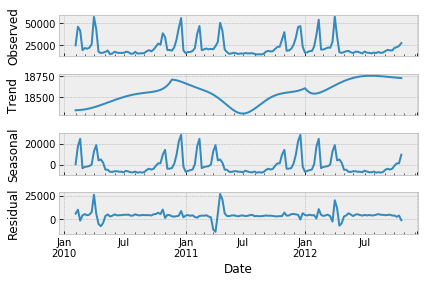

In [77]:
decomp.plot();

In [78]:
fcast = forecast(decomp, steps=39, fc_func=drift, seasonal=True)

fcast

,drift+seasonal
2012-11-02,32950.423577
2012-11-09,14991.912738
2012-11-16,15155.285147
2012-11-23,15696.275981
2012-11-30,19733.668109
2012-12-07,28228.367198
2012-12-14,41168.293720
2012-12-21,47184.083949
2012-12-28,17060.166280
2013-01-04,12095.900321


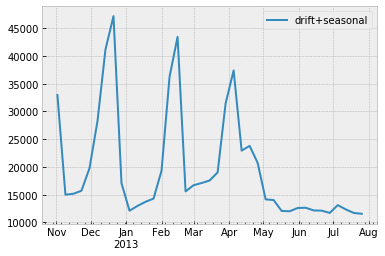

In [79]:
fcast.plot()

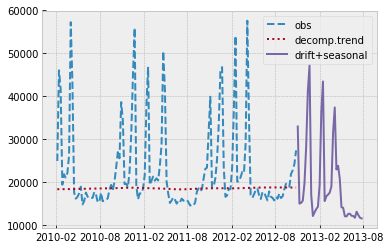

In [80]:
plt.plot(ts_1['Weekly_Sales'], '--', label='obs')
plt.plot(decomp.trend, ':', label='decomp.trend')
plt.plot(fcast, '-', label=fcast.columns[0])
plt.legend();

<b>Dickey-Fuller Test

Let's run the Dicky Fuller Test on the timeseries and verify the null hypothesis that the TS is non-stationary.

In [81]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

In [82]:
adfuller(ts_1['Weekly_Sales'])

(-2.5221638686500385,
 0.1101743228258697,
 6,
 136,
 {'1%': -3.4793722137854926,
  '5%': -2.8830370378332995,
  '10%': -2.578233635380623},
 2638.475060753871)

In [83]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_1['Weekly_Sales'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.522164
p-value                          0.110174
#lags Used                       6.000000
Number of Observations Used    136.000000
Critical Value (1%)             -3.479372
Critical Value (5%)             -2.883037
Critical Value (10%)            -2.578234
dtype: float64


In [84]:
ts_1_log = np.log10(ts_1['Weekly_Sales'])

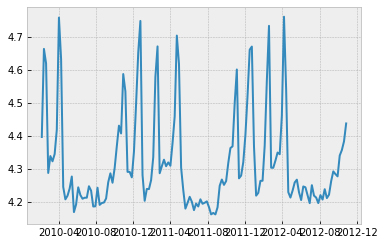

In [85]:
plt.plot(ts_1_log)

In [86]:

# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_1_log)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.061511
p-value                          0.029536
#lags Used                      10.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64


In [87]:
ts_diff = ts_1['Weekly_Sales'].diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
ts_diff.dropna(inplace=True)

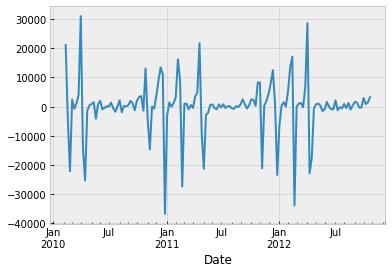

In [88]:
ts_diff.plot()

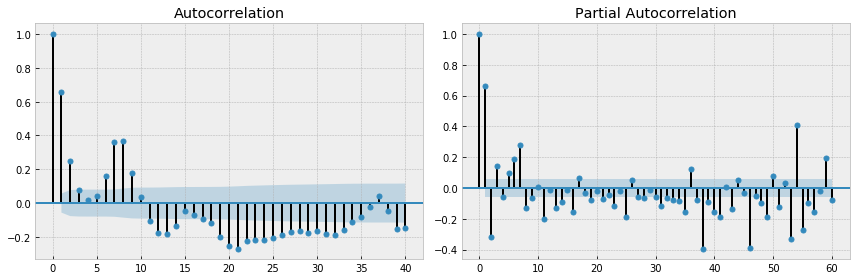

In [89]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(ts_1_log, lags=40, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(ts_1_log, lags=60, ax=axes[1], alpha=0.5, method='ols')
plt.tight_layout()

In [90]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [91]:
import warnings
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(ts_1_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}52 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(1, 0, 0, 52)52 model - AIC:-221.74866805635304


In [92]:

best_model = sm.tsa.statespace.SARIMAX(ts_1_log,
                                      order=(1, 1, 1),
                                      seasonal_order=(1, 0, 0, 52),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

In [93]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(1, 1, 1)x(1, 0, 0, 52)   Log Likelihood                 114.874
Date:                            Tue, 15 Oct 2019   AIC                           -221.749
Time:                                    13:29:43   BIC                           -209.925
Sample:                                02-05-2010   HQIC                          -216.944
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3799      0.143     -2.658      0.008      -0.660      -0.100
ma.L1          0.6827      0.132   

In [94]:
ts_1['Weekly_Sales']

Date
2010-02-05    24924.50
2010-02-12    46039.49
2010-02-19    41595.55
2010-02-26    19403.54
2010-03-05    21827.90
2010-03-12    21043.39
2010-03-19    22136.64
2010-03-26    26229.21
2010-04-02    57258.43
2010-04-09    42960.91
2010-04-16    17596.96
2010-04-23    16145.35
2010-04-30    16555.11
2010-05-07    17413.94
2010-05-14    18926.74
2010-05-21    14773.04
2010-05-28    15580.43
2010-06-04    17558.09
2010-06-11    16637.62
2010-06-18    16216.27
2010-06-25    16328.72
2010-07-02    16333.14
2010-07-09    17688.76
2010-07-16    17150.84
2010-07-23    15360.45
2010-07-30    15381.82
2010-08-06    17508.41
2010-08-13    15536.40
2010-08-20    15740.13
2010-08-27    15793.87
                ...   
2012-04-06    57592.12
2012-04-13    34684.21
2012-04-20    16976.19
2012-04-27    16347.60
2012-05-04    17147.44
2012-05-11    18164.20
2012-05-18    18517.79
2012-05-25    16963.55
2012-06-01    16065.49
2012-06-08    17666.00
2012-06-15    17558.82
2012-06-22    16633.41
2012-0

In [95]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-06-01') ,full_results=True)

In [96]:
pred_dynamic.predicted_mean

2012-06-01    4.218501
2012-06-08    4.202116
2012-06-15    4.245443
2012-06-22    4.250392
2012-06-29    4.209110
2012-07-06    4.207068
2012-07-13    4.257447
2012-07-20    4.204098
2012-07-27    4.224981
2012-08-03    4.175319
2012-08-10    4.227353
2012-08-17    4.196727
2012-08-24    4.254077
2012-08-31    4.203926
2012-09-07    4.270205
2012-09-14    4.266050
2012-09-21    4.294663
2012-09-28    4.283480
2012-10-05    4.307941
2012-10-12    4.374384
2012-10-19    4.351210
2012-10-26    4.467308
Freq: W-FRI, dtype: float64

In [134]:
tk= np.power(10, pred_dynamic.predicted_mean)

In [135]:
forecast = tk
actual = ts_1['2012-06-01':]['Weekly_Sales']

In [136]:
actual

Date
2012-06-01    16065.49
2012-06-08    17666.00
2012-06-15    17558.82
2012-06-22    16633.41
2012-06-29    15722.82
2012-07-06    17823.37
2012-07-13    16566.18
2012-07-20    16348.06
2012-07-27    15731.18
2012-08-03    16628.31
2012-08-10    16119.92
2012-08-17    17330.70
2012-08-24    16286.40
2012-08-31    16680.24
2012-09-07    18322.37
2012-09-14    19616.22
2012-09-21    19251.50
2012-09-28    18947.81
2012-10-05    21904.47
2012-10-12    22764.01
2012-10-19    24185.27
2012-10-26    27390.81
Name: Weekly_Sales, dtype: float64

In [133]:
MAPE = np.mean(np.abs(actual - forecast)/actual)

In [117]:
print('The Mean Absolute percentage error of our forecast for last two years is {}'.format(round(MAPE, 4)))

The Mean Absolute percentage error of our forecast for last two years is 0.0572


In [118]:
# Compute the mean square error
mse = ((actual - forecast) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The ROOT Mean Squared Error of our forecasts is {}'.format(np.sqrt(round(mse, 4))))

The Mean Squared Error of our forecasts is 1467628.1733
The ROOT Mean Squared Error of our forecasts is 1211.4570455860166


In [119]:
#Forecast for next 39 Weeks

In [120]:
np.power(10, best_results.forecast(steps=39))

2012-11-02    30078.286516
2012-11-09    20239.797118
2012-11-16    20354.726675
2012-11-23    21440.465713
2012-11-30    23738.697094
2012-12-07    27539.228903
2012-12-14    32681.426817
2012-12-21    33071.353798
2012-12-28    22742.529688
2013-01-04    18903.800493
2013-01-11    19103.680967
2013-01-18    19982.341465
2013-01-25    19989.989679
2013-02-01    22826.232043
2013-02-08    29137.851107
2013-02-15    35747.409210
2013-02-22    20991.692609
2013-03-01    20985.403687
2013-03-08    21556.056886
2013-03-15    22221.198829
2013-03-22    22082.109220
2013-03-29    25535.878865
2013-04-05    36987.248519
2013-04-12    28145.463953
2013-04-19    19153.460253
2013-04-26    18768.069845
2013-05-03    19257.307823
2013-05-10    19864.278401
2013-05-17    20071.667542
2013-05-24    19145.776134
2013-05-31    18592.887944
2013-06-07    19568.884601
2013-06-14    19504.835051
2013-06-21    18944.133005
2013-06-28    18378.180063
2013-07-05    19662.603215
2013-07-12    18902.844665
2

In [121]:
# Get forecast 39 steps (39 weeks) ahead in future
n_steps = 39
pred_uc_99 = best_results.get_forecast(steps=39, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=39, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [122]:
pred_ci_99.head()

,lower Weekly_Sales,upper Weekly_Sales
2012-11-02,4.280047,4.676459
2012-11-09,3.980689,4.631723
2012-11-16,3.906941,4.710390
2012-11-23,3.861173,4.801295
2012-11-30,3.847313,4.903601


In [123]:


pred_ci_95.head()

,lower Weekly_Sales,upper Weekly_Sales
2012-11-02,4.280047,4.676459
2012-11-09,3.980689,4.631723
2012-11-16,3.906941,4.710390
2012-11-23,3.861173,4.801295
2012-11-30,3.847313,4.903601


In [124]:
n_steps = 39
idx = pd.date_range(ts_1['Weekly_Sales'].index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])

In [125]:
fc_99.head()

,lower_ci_99,upper_ci_99
2012-11-01,19056.667551,47474.371755
2012-12-01,9565.089881,42827.552328
2013-01-01,8071.247320,51332.202027
2013-02-01,7263.957112,63284.180086
2013-03-01,7035.786886,80094.202517


In [126]:
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2012-11-01,30078.286516,19056.667551,47474.371755,19056.667551,47474.371755
2012-12-01,20239.797118,9565.089881,42827.552328,9565.089881,42827.552328
2013-01-01,20354.726675,8071.247320,51332.202027,8071.247320,51332.202027
2013-02-01,21440.465713,7263.957112,63284.180086,7263.957112,63284.180086
2013-03-01,23738.697094,7035.786886,80094.202517,7035.786886,80094.202517


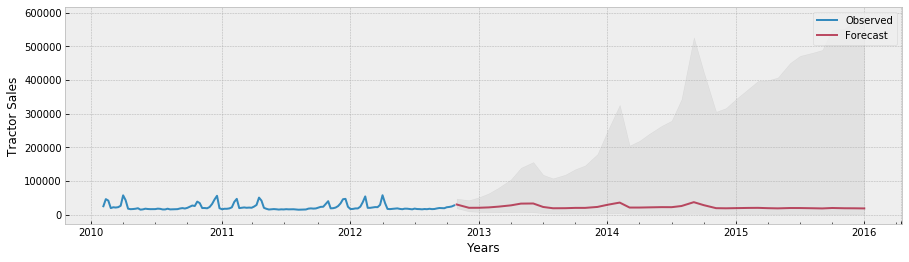

In [127]:
# plot the forecast along with the confidence band
axis = ts_1['Weekly_Sales'].plot(label='Observed', figsize=(15, 4))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
#axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.05)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

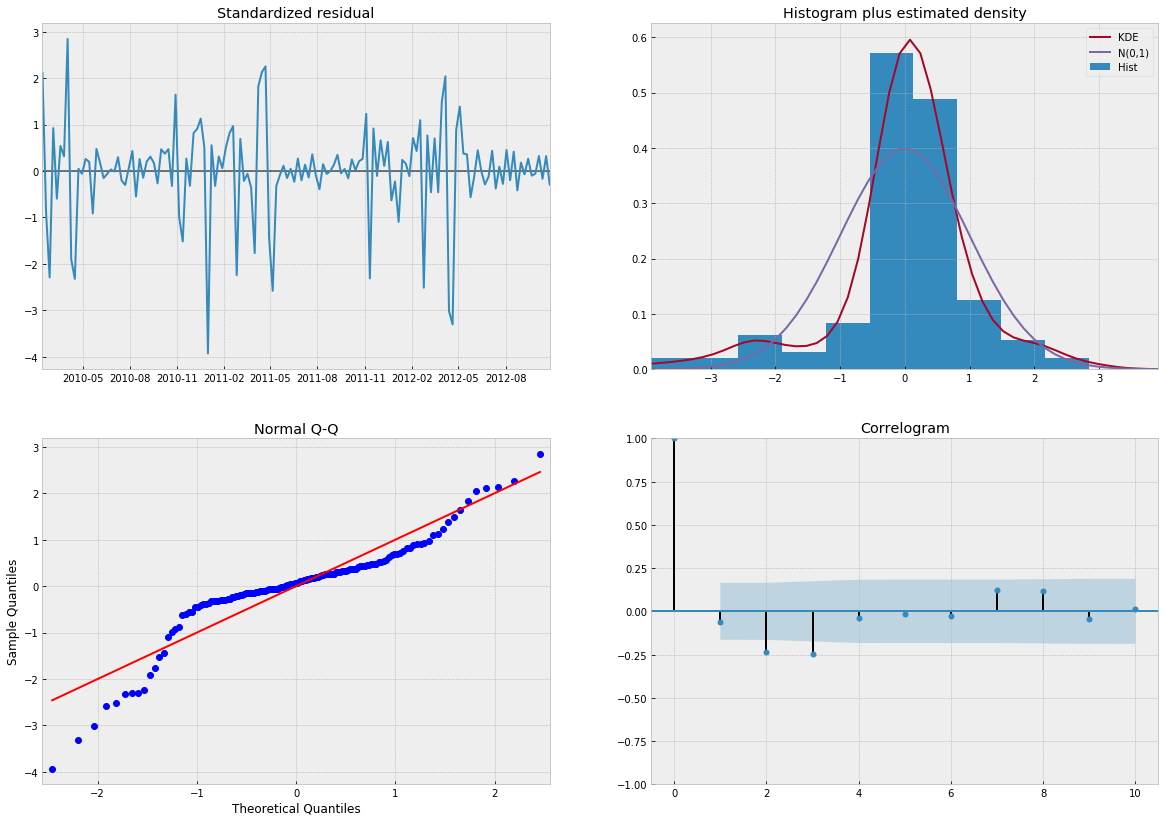

In [128]:

best_results.plot_diagnostics(figsize=(20, 14))
plt.show()